In [1]:
import VisionTransformer as vit

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from datetime import datetime
from gc import collect
from os import cpu_count
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

2022-11-10 12:57:40.861688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 12:57:40.983080: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 12:57:41.427173: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-10 12:57:41.427214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [3]:
collect()
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cuda


## Taxonomy of an inverse problem
Ongie, G., Jalal, A., Metzler, C. A., Baraniuk, R. G., Dimakis, A. G. & Willett, R. (2020). Deep Learning Techniques for Inverse Problems in Imaging. IEEE Journal on Selected Areas in Information Theory, 1(1), 39–56. https://doi.org/10.1109/jsait.2020.2991563

<h4><center>$y = A(x) + \epsilon$</center></h4>

- $y$: measurement (e.g. displacements)
- $x$: signal (e.g. traction forces)
- $A$: (non-linear) foward operator
- $\epsilon$: noise

__Goal__: recover $x$ from $y$

__Problem__: A is ill-posed, (matrix-) inversion is not possible


__Approach__: 
  1. Supervised: create a matched dataset by simulating the forward operator on clean data
  2. Train model to reconstruct signal by taking (corrupted) measurements as input
  3. Generalize to unseen measurements

## Comparison: CNN from Kratz et al. and ViT

In [4]:
vit_weights = vit.VisionTransformer(dspl_size=104, patch_size=8, embed_dim=128, depth=12, n_heads=8, mlp_ratio=4.,p=0., attn_p=0.,drop_path=0).double()

In [5]:
if torch.cuda.is_available():
    vit_weights.load_state_dict(torch.load('logs_and_weights/ViT-2022-Nov-03 09:55:11/ViT-2022-Nov-03 09:55:11_best_val_loss_2e-05.pth')['best_model_weights'], strict=False)
else:
    vit_weights.load_state_dict(torch.load('logs_and_weights/ViT-2022-Nov-03 09:55:11/ViT-2022-Nov-03 09:55:11_best_val_loss_2e-05.pth', map_location=torch.device('cpu'))['best_model_weights'], strict=False)        

In [6]:
cnn_weights = keras.models.load_model('../mltfm/models/model_noise_1e-4.h5')

2022-11-10 12:57:43.860179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 12:57:43.860488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-11-10 12:57:43.860520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2022-11-10 12:57:43.860549: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-11-10 12:57:43.860578: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could no

In [7]:
dspl = h5py.File('data/displacements_25.h5')["data"]
trac = h5py.File('data/tractions_25.h5')["data"]

dspl_ = np.moveaxis(np.array(dspl),3 ,1)
trac_ = np.moveaxis(np.array(trac),3 ,1)

X_test = torch.from_numpy(dspl_).double()
Y_test = torch.from_numpy(trac_).double()

In [8]:
pred_vit, _ = vit_weights(X_test)
pred_cnn = cnn_weights.predict(dspl)

1/1 [==============================] - 0s 220ms/step


In [9]:
loss = torch.nn.MSELoss(reduction='none')
loss_vit = torch.sum(loss(pred_vit, Y_test), (1, 2, 3))
loss_cnn = torch.sum(loss(torch.tensor(np.moveaxis(pred_cnn, 3, 1)), Y_test), (1, 2, 3))

loss_vit = torch.reshape(loss_vit, (25, 1))
loss_cnn = torch.reshape(loss_cnn, (25, 1))

In [10]:
pd.DataFrame(np.array(torch.cat((loss_vit, loss_cnn), 1).detach().numpy()), columns=['loss_ViT', 'loss_CNN'])

,loss_ViT,loss_CNN
0,2.753814,0.953331
1,4.901701,2.071338
2,2.239506,0.819685
3,2.465992,1.019594
4,3.118751,1.171545
5,4.250527,1.809745
6,2.809118,1.016019
7,5.284278,2.160380
8,3.905215,1.641007
9,6.274332,2.361687


<IPython.core.display.Javascript object>


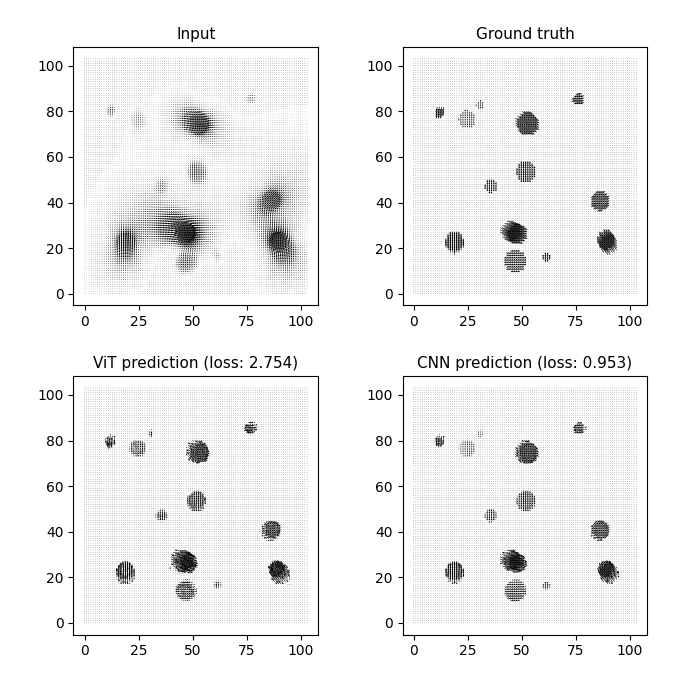

Text(0.5, 1.0, 'CNN prediction (loss: 0.953)')

In [11]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(2,2, figsize=(7, 7))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(dspl[0,:,:,0], dspl[0,:,:,1], scale=1)
axs[0, 0].set_title('Input', {'fontsize': 11})

axs[0, 1].quiver(trac[0,:,:,0], trac[0,:,:,1], scale=10)
axs[0, 1].set_title('Ground truth', {'fontsize': 11})

axs[1, 0].quiver(pred_vit[0,0,:,:].detach().numpy(), pred_vit[0,1,:,:].detach().numpy(), scale=10)
axs[1, 0].set_title(f'ViT prediction (loss: {torch.round(loss_vit[0,0], decimals=3)})', {'fontsize': 11})

axs[1, 1].quiver(pred_cnn[0,:,:,0], pred_cnn[0,:,:,1], scale=10)
axs[1, 1].set_title(f'CNN prediction (loss: {torch.round(loss_cnn[0,0], decimals=3)})', {'fontsize': 11})

## Optimization possibilities

- Complexity of decoder (linear layer, FFNN, Convolutions, 'proper' decoder)
- Pretraining on low-resolution samples and finetuning on high resolution
- Multitask learning:
        - MSE
        - Classification: Split dataset in three groups, corrupt each group with Gaussian noise of different magnitude, infer label
        - Deviation of Traction Magnitude at Adhesions (DTMA)
        - Deviation of Traction Magnitude in the Background (DTMB)
        - Signal to Noise Ratio (SNR)
        - Deviation of Traction Direction at Adhesions (DDA)
- Hyperparameters: 
        - Depth of encoder/decoder
        - patch size
        - embedding dimension
        - number of attention heads
        - mlp ratio (number of hidden layers in MLP module)
        - dropout, attention dropout and stochastic path prob
        - weight initialization
        - optimizer
        - learning rate schedule
        - ... 

## Visualizing attention maps

Get attention scores of each layer for an input sample.

In [25]:
sys.path.append(f"{os.path.dirname(os.getcwd())}/DL_TFM/scripts/")
from data_preparation import matFiles_to_npArray

In [26]:
X_test = matFiles_to_npArray('../comparables/generic')[1] # each dict has keys ['brdx', 'brdy', 'dspl', 'name']
Y_test = matFiles_to_npArray('../comparables/generic')[0] # each dict has keys ['brdx', 'brdy', 'dspl', 'name']

In [27]:
X_test = np.moveaxis(np.array(X_test['dspl'])[np.newaxis, ...], 3, 1)
Y_test = np.moveaxis(np.array(Y_test['trac'])[np.newaxis, ...], 3, 1)

In [28]:
pred, attn_scores = vit_weights(torch.tensor(X_test).double())

In [29]:
attn_mat = torch.stack(attn_scores)
attn_mat = attn_mat.squeeze(1)

# Average the attention weights across all heads.
attn_mat = torch.mean(attn_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_attn = torch.eye(attn_mat.size(1))
aug_attn_mat = attn_mat + residual_attn
aug_attn_mat = aug_attn_mat / aug_attn_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_attn_mat.size())
joint_attentions[0] = aug_attn_mat[0].double()
for n in range(1, aug_attn_mat.size(0)):
    joint_attentions[n] = aug_attn_mat[n].double() @ joint_attentions[n-1].double()

last_attn = joint_attentions[-1]

In [31]:
grid_size = int(np.sqrt(aug_attn_mat.size(-1)))
mask = last_attn[0, 0:].reshape(grid_size, grid_size).detach().numpy()

In [33]:
from cv2 import resize
mask = resize(mask / mask.max(), (104, 104))

<IPython.core.display.Javascript object>


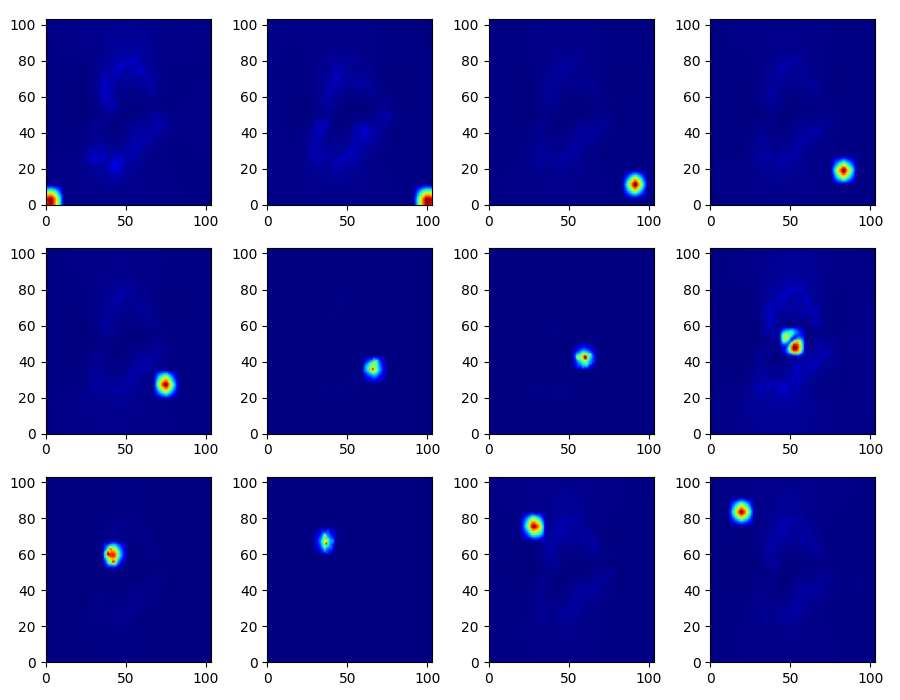

In [42]:
fig, axs = plt.subplots(3,4, figsize=(9, 7))
fig.tight_layout(pad=1, w_pad=1, h_pad=1)
ind = 0
for i in range(0, 3):
    for j in range(0, 4):
        # Attention from the output token to the input space.
        mask = joint_attentions[0][0:, ind].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test[0,:,:,:]

        # axs[0].quiver(X_test[0,0,:,:], X_test[0,1,:,:], scale=10)
        # axs[0].set_title('Input', {'fontsize': 11})

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        # fig.colorbar(im, ax=axs[1])
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        # axs[i, j].set_title('Attention heatmap', {'fontsize': 11})
        ind += 12        


<IPython.core.display.Javascript object>


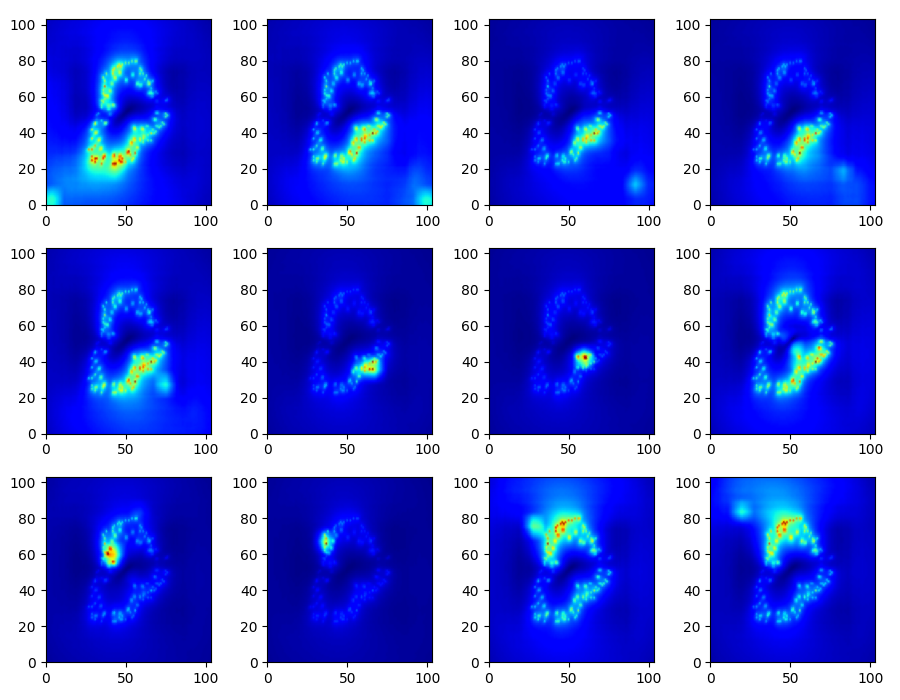

In [43]:
fig, axs = plt.subplots(3,4, figsize=(9, 7))
fig.tight_layout(pad=1, w_pad=1, h_pad=1)
ind = 0
for i in range(0, 3):
    for j in range(0, 4):
        # Attention from the output token to the input space.
        mask = joint_attentions[5][0:, ind].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test[0,:,:,:]

        # axs[0].quiver(X_test[0,0,:,:], X_test[0,1,:,:], scale=10)
        # axs[0].set_title('Input', {'fontsize': 11})

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        # fig.colorbar(im, ax=axs[1])
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        # axs[i, j].set_title('Attention heatmap', {'fontsize': 11})
        ind += 12        


<IPython.core.display.Javascript object>


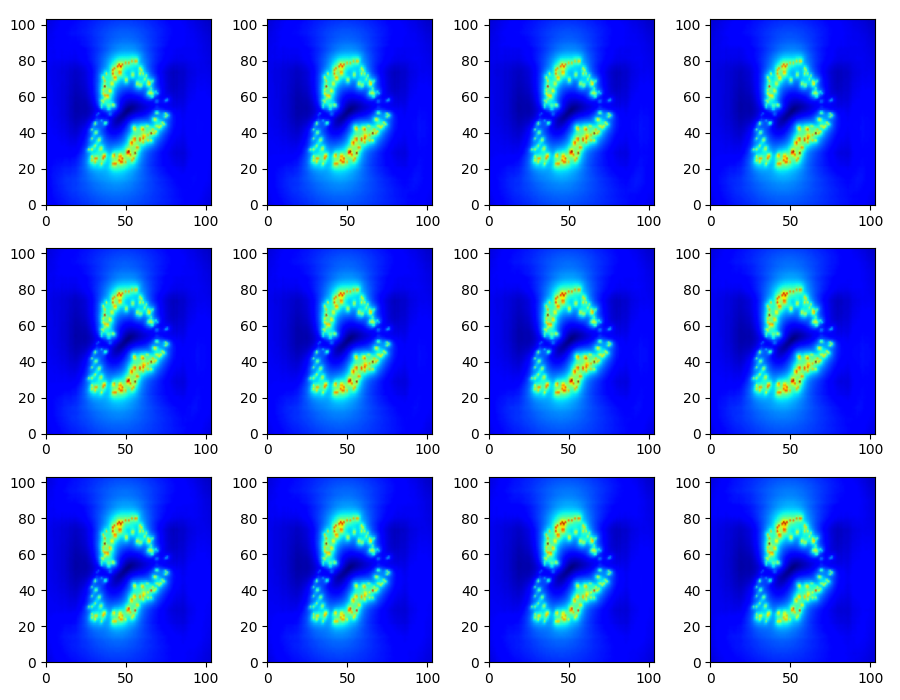

In [44]:
fig, axs = plt.subplots(3,4, figsize=(9, 7))
fig.tight_layout(pad=1, w_pad=1, h_pad=1)
ind = 0
for i in range(0, 3):
    for j in range(0, 4):
        # Attention from the output token to the input space.
        mask = joint_attentions[11][0:, ind].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test[0,:,:,:]

        # axs[0].quiver(X_test[0,0,:,:], X_test[0,1,:,:], scale=10)
        # axs[0].set_title('Input', {'fontsize': 11})

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        # fig.colorbar(im, ax=axs[1])
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        # axs[i, j].set_title('Attention heatmap', {'fontsize': 11})
        ind += 12        


In [ ]:
grid_size

In [ ]:
mask = last_att.reshape(grid_size, grid_size).detach().numpy()

In [ ]:
mask = last_att.detach().numpy().repeat(9, 1).repeat(9, 0)
mask = mask / mask.max()
mask = np.concatenate((mask[:,:, np.newaxis], mask[:,:, np.newaxis]), axis=2)

In [ ]:
result = X_test[0,:,:,:] * mask

In [ ]:
last_att = joint_attentions[-1]

In [ ]:
last_att.shape

In [ ]:
last_att = last_att.detach().numpy()

In [ ]:
last_att

In [ ]:
last_att.shape

In [ ]:
last_att = last_att.repeat(2, 1).repeat(2, 0)

In [ ]:
last_att

In [ ]:
last_att.shape

In [ ]:
last_att = np.concatenate((last_att[:,:, np.newaxis], last_att[:,:, np.newaxis]), axis=2)

In [ ]:
last_att.shape

In [ ]:
last_att[:,:,0] == last_att[:,:,1],

In [ ]:
last_att[:,:,0]

In [ ]:
last_att[0,:,0]

In [ ]:
sample = np.full((6,6,2),fill_value=1)

In [ ]:
sample.shape

In [ ]:
res = sample * last_att

In [ ]:
res[:,:,0]